In [28]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [3]:
city_info = pd.read_csv('data/city_info.csv',parse_dates=['Stn.stDate', 'Stn.edDate']).dropna()
city_info['Stn.stDate'] = pd.to_datetime(city_info['Stn.stDate'])
city_info['Stn.edDate'] = pd.to_datetime(city_info['Stn.edDate'])
indices = city_info['ID'].unique()
for ind in indices:
    mask = city_info['ID'] == ind
    if city_info.loc[mask].shape[0] > 1:
        best_start = np.min(city_info.loc[mask, 'Stn.stDate'].values)
        best_end_ind = np.argmax(city_info.loc[mask, 'Stn.edDate'].values)
        best_ind = [i for i,m in enumerate(mask) if m][best_end_ind]
        city_info.loc[best_ind ,'Stn.stDate'] = best_start
        mask_ = [not m for m in mask]
        mask_[best_ind] = True
        city_info = city_info.loc[mask_]
        city_info.index = range(city_info.shape[0])
city_info.set_index('ID', inplace=True)
city_info.head()


,Unnamed: 0,Name,Lat,Lon,Stn.Name,Stn.stDate,Stn.edDate
ID,,,,,,,
USW00024021,2,Lander,42.8153,-108.7261,LANDER HUNT FIELD,1892-01-01,2020-12-31
USW00024018,4,Cheyenne,41.1519,-104.8061,CHEYENNE MUNICIPAL ARPT,1871-01-01,2020-12-31
USW00014897,6,Wausau,44.9258,-89.6256,Wausau Airport,1896-01-01,2020-12-31
USW00094973,8,Hayward,46.0261,-91.4442,Hayward Muni AP,1894-01-01,2020-12-31
USW00014991,10,EauClaire,44.8664,-91.4878,Eau Claire Chippewa Valley Regional Airport,1893-01-01,2020-12-31


In [4]:
city_weather = {}
for ind,name in zip(city_info.index, city_info['Name']):
    end_bound = datetime(month = 12, year= 2020, day=31)
    start_bound = datetime(month = 1, year= 2020, day=1)
    if city_info.loc[ind, 'Stn.stDate'] <= start_bound and city_info.loc[ind, 'Stn.edDate'] >=  end_bound :
        temp = pd.read_csv('data/' + str(ind) + '.csv', parse_dates=['Date']).dropna()
        temp['Date'] = pd.to_datetime(temp['Date']).values
        temp = temp.loc[(temp['Date'] >= start_bound) & (temp['Date'] <= end_bound),:]
        temp.set_index('Date', inplace=True)
        city_weather[ind] = temp


In [86]:
deltas = pd.DataFrame(columns=['delta_min', 'delta_max','sqdelta_min', 'sqdelta_max'], index=city_info.index)
day_dt = timedelta(days=1)
for city in tqdm(city_weather.keys()):
    delta = np.zeros((4,))
    curr_date = city_weather[city].index.min()
    days = 0
    while curr_date <= city_weather[city].index.max():
        next_date = curr_date + day_dt
        if next_date in city_weather[city].index and curr_date in city_weather[city].index:
            ln_delta = np.abs(city_weather[city].loc[next_date,['tmin','tmax']].values - city_weather[city].loc[curr_date,['tmin','tmax']].values)
            sq_delta = np.square(ln_delta)
            delta += np.array(ln_delta.tolist() + sq_delta.tolist())
            days += 1
        curr_date = next_date
    deltas.loc[city] = delta/days

deltas['Name'] = city_info['Name']
deltas['Score'] = (deltas['sqdelta_max']+deltas['sqdelta_min'])/2
deltas.describe()

 32%|███▏      | 67/210 [00:25<00:53,  2.68it/s]<ipython-input-86-8663ca2ca168>:15: RuntimeWarning: invalid value encountered in true_divide
  deltas.loc[city] = delta/days
100%|██████████| 210/210 [01:18<00:00,  2.67it/s]


,delta_min,delta_max,sqdelta_min,sqdelta_max,Name,Score
count,209.000000,209.00000,209.000000,209.000000,210,209.00000
unique,209.000000,209.00000,209.000000,209.000000,210,209.00000
top,5.334986,5.54411,49.799178,62.646203,NewYork,56.36163
freq,1.000000,1.00000,1.000000,1.000000,1,1.00000


In [108]:
def merc_from_arrays(lats, lons):
    r_major = 6378137.000
    x = r_major * np.radians(lons)
    scale = x/lons
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + lats * (np.pi/180.0)/2.0)) * scale
    return (x, y)
def score_to_color(score,max_score):
    if pd.isna(score):
        return 'black'
    score_ = score/max_score
    r = str(hex(int(255*score_))).split('x')[-1]
    if len(r) == 1:
        r = '0' + r
    b = str(hex(int(255*(1-score_)))).split('x')[-1]
    if len(b) == 1:
        b = '0' + b
    return '#' + r + b + '00'

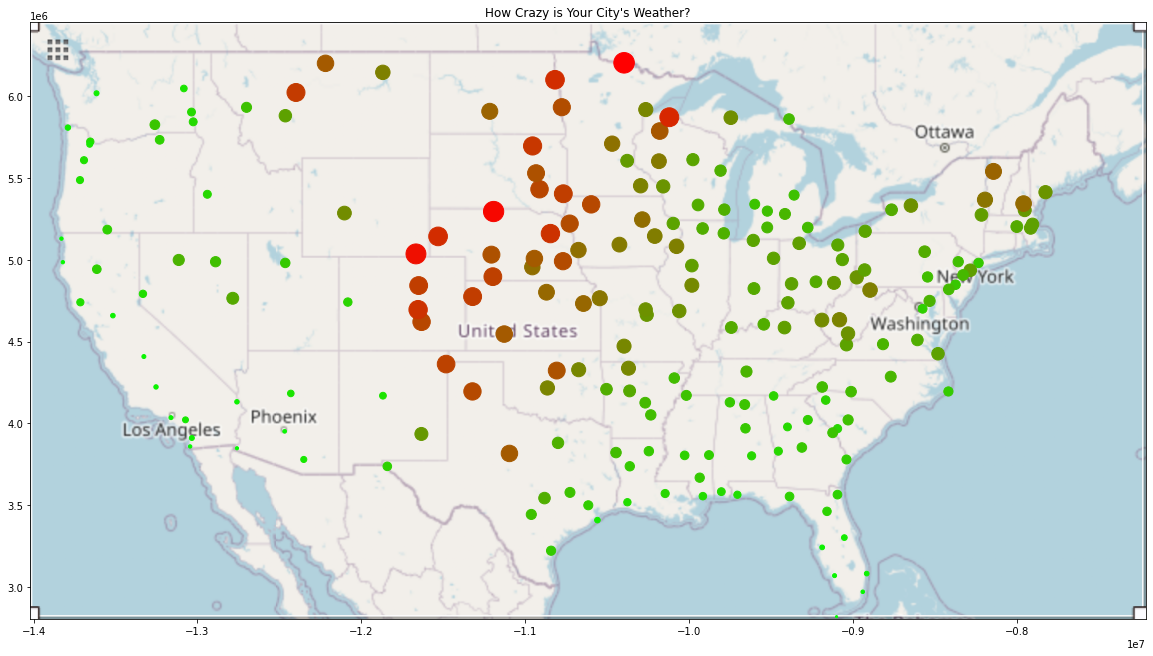

In [112]:
deltas['Score_plt'] = (deltas['Score']**2)/20
max_score = deltas['Score_plt'].max()
deltas['Color'] = deltas['Score_plt'].apply(lambda x: score_to_color(x, max_score))

BBox = (-125.95, -64.78,      
         24.45,50.01)
lon_b = np.array([-125.95, -64.78])
lat_b = np.array([24.45, 50.01])
BBox = np.array(merc_from_arrays(lat_b,lon_b)).reshape((-1,))
mappng = plt.imread('usmap.png')
fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(mappng, extent = BBox, aspect= 'equal')
lons = [city_info.loc[city_id,'Lon'] for city_id in city_weather.keys()]
lats = [city_info.loc[city_id,'Lat'] for city_id in city_weather.keys()]
x,y = merc_from_arrays(np.array(lats), np.array(lons))
s = [deltas.loc[city_id,'Score_plt'] for city_id in city_weather.keys()]
c = [deltas.loc[city_id,'Color'] for city_id in city_weather.keys()]

ax.scatter(x,y, c=c, s=s)
ax.set_title('How Crazy is Your City\'s Weather?')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
#save figure
plt.savefig('CrazyWeather.png', dpi=300)



In [110]:
deltas.sort_values(by='Score', ascending=False)

,delta_min,delta_max,sqdelta_min,sqdelta_max,Name,Score,Score_plt,Color
ID,,,,,,,,
USW00014918,7.71524,6.24598,113.781,69.807,InternationalFalls,91.794,421.307,#ff0000
USW00024032,6.22,8.48493,64.8792,116.08,Valentine,90.4797,409.329,#f70700
USW00024018,5.1126,8.33918,49.6194,128.452,Cheyenne,89.0357,396.368,#ef0f00
USW00094929,6.83642,7.19007,87.0843,81.7277,Ashland,84.406,356.219,#d72700
USW00024028,4.84411,8.56575,40.3532,126.543,Scottsbluff,83.4479,348.178,#d22c00
...,...,...,...,...,...,...,...,...
USW00024213,2.95616,2.82356,14.9967,14.7896,Eureka,14.8932,11.0903,#06f800
USW00023188,2.19425,3.05918,9.30556,20.3494,SanDiego,14.8275,10.9927,#06f800
USW00003145,2.71629,3.01713,12.2616,15.9303,Yuma,14.096,9.93482,#06f800
